In [1]:
import os
import numpy as np
import pandas as pd
from fish_helpers import *
import matplotlib as mpl
import scipy.cluster.hierarchy as shc

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def inspect_node(node):
    if 'leaf_attributes' in node.keys():
        attributes = node['leaf_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        a = 'None'
        b = 'None'
        children = False
    else:
        attributes = node['node_attributes'][0]
        c = attributes['node_id']
        h = attributes['height']
        children = node['children']
        a_node = node['children'][0]
        if 'leaf_attributes' in a_node.keys():
            a = a_node['leaf_attributes'][0]['node_id']
        else:
            a = a_node['node_attributes'][0]['node_id']
        b_node = node['children'][1]
        if 'leaf_attributes' in b_node.keys():
            b = b_node['leaf_attributes'][0]['node_id']
        else:
            b = b_node['node_attributes'][0]['node_id']
    return c,h,a,b,children

In [3]:
def json2linkage(data):
    C = []
    H = []
    A = []
    B = []
    node_dict = {}

    node = data
    c,h,a,b,children = inspect_node(node)
    C.append(c)
    H.append(h)
    A.append(a)
    B.append(b)
    while len(children)>0:
        new_children = []
        for node in children:
            c,h,a,b,node_children = inspect_node(node)
            C.append(c)
            H.append(h)
            A.append(a)
            B.append(b)
            if isinstance(node_children,list):
                new_children.extend(node_children)
        children = new_children
    linkage = pd.DataFrame()
    linkage['C'] = C
    linkage['H'] = H
    linkage['A'] = A
    linkage['B'] = B
    sorted_linkage = linkage[linkage['H']>0]
    sorted_linkage = sorted_linkage.sort_values('H',ascending=True)
    return sorted_linkage

In [4]:
def formatSHClinkage(linkage):
    sorted_linkage = linkage.sort_values('H',ascending=True)
    nodes = list(sorted_linkage['C'])
    leaves = np.array(list(sorted_linkage['A'])+list(sorted_linkage['B']))
    leaves = [i for i in leaves if not i in nodes]
    node_index_dictionary = {node:i for i,node in enumerate(list(leaves)+list(nodes))}
    linkage_shc = np.zeros((len(sorted_linkage),4))
    linkage_shc[:,0] = np.array([node_index_dictionary[node] for node in sorted_linkage['A']])
    linkage_shc[:,1] = np.array([node_index_dictionary[node] for node in sorted_linkage['B']])
    linkage_shc[:,2] = sorted_linkage['H']
    linkage_shc[:,3] = 1
    return linkage_shc,leaves

In [5]:
plt.style.use(['dark_background'])
def plot_dendrogram(linkage,accuracy_matrix):
    Z = linkage.copy()
    Z[:,2] = np.log10(Z[:,2]+1)
    cmap = mpl.cm.plasma(accuracy_matrix)
    temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
    link_cols = {}
    for i,c in enumerate(temp):
        link_cols[i] = c
    ax = plt.figure(figsize=[5,10])
    D = shc.dendrogram(Z=Z,
                       link_color_func=lambda x: link_cols[x],
                       orientation='left',no_labels=True)
    norm = mpl.colors.Normalize(vmin=0,vmax=1)
    sm = mpl.pyplot.cm.ScalarMappable(norm=norm,cmap='plasma')
    sm.set_array([])
    plt.colorbar(sm)
    plt.show()

In [6]:
def find_next_node(i,df):
    temp = df[(df['A']==i)|(df['B']==i)]
    if len(temp)==1:
        return temp['C'].iloc[0]
    else:
        return False
def linkage2binary(linkage,leaves):
    nnodes = len(linkage)
    nodes = list(linkage['C'])
    nodes_index_dictionary = {node:i for i,node in enumerate(nodes)}
    nleaves = len(leaves)
    binary_node_matrix = np.zeros((nleaves,nnodes))
    for i,leaf in enumerate(leaves):
        new_node = find_next_node(leaf,linkage)
        while isinstance(new_node,str):
            node_loc = nodes_index_dictionary[new_node]
            binary_node_matrix[i,node_loc]=1
            new_node = find_next_node(new_node,linkage)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=leaves,columns=nodes)
    return binary_node_df

In [7]:
"""
Original Data is in Allen JSON format
"""
base = '/bigstore/binfo/mouse/Hippocampus/'
import json
with open(os.path.join(base,'dend.json')) as json_file:
    data = json.load(json_file)

In [8]:
"""
First I convert it to a linkage 
where each node and leaf has a 
name that is used in the allen format
['C'] is the name of the node
['A'] and ['B'] are the names of the children of the nodes
['H'] is the height of the node within the dendrogram
"""
linkage = json2linkage(data)
linkage

,C,H,A,B
558,n173,0.0120,L4/5 IT_9,L4/5 IT_10
456,n56,0.0130,L6 CT_9,L6 CT_10
561,n177,0.0131,L4/5 IT_13,L4/5 IT_14
564,n165,0.0138,L5 IT_8,L5 IT_9
418,n265,0.0159,Sst_10,Sst_11
...,...,...,...,...
4,n274,0.5365,n277,n275
5,n283,0.5418,n284,n288
1,n2,0.6271,n3,n274
2,n281,0.7175,n283,n282


In [9]:
"""
Next I convert the linkage to a df
the columns are the lowest level cell types
the columns are the names of the nodes
if the cell type is in the node the value is 1
"""
metadata = pd.read_csv(os.path.join(base,'sample_annotations.csv'),index_col=0)
good_types = [i for i in metadata['cell_type_alias_label'].unique() if (not 'Doub' in i)&(not 'Quality' in i)&(not 'Unknown' in i)]
binary_node_df = linkage2binary(linkage,good_types).T
binary_node_df

/home/zach/miniconda3/envs/pyspots/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (36,54) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,L2/3 IT Otof_6,L4/5 IT_15,L2/3 IT Otof_5,L5 IT_9,L4/5 IT_9,L5 IT_11,L6 IT_4,L5 IT_5,L5 IT_4,L4/5 IT_14,...,SUB-Sp Ndst4_4,Ly6g6e_1,CA1sp/SUB-sp Kcnip1_2,L6 CT_13,L2/3 IT Cxcl14_7,L2/3 IT Cdc14a_1,L2/3 IT Cxcl14_3,L2/3 IT Cxcl14_8,L2/3 IT Cxcl14_4,L2/3 IT Cxcl14_6
n173,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n165,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
n281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


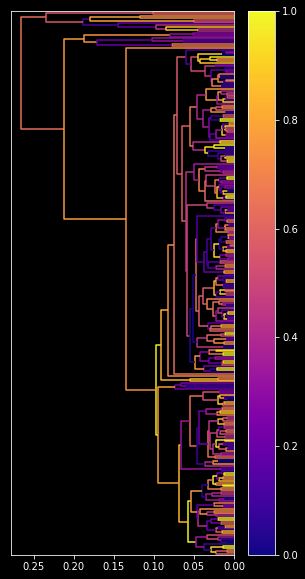

In [10]:
"""
The last is just for visualization
I convert the linkage with allen names to indexes
this is the format that scipy.cluster.hierarchy uses
I also added a function that allows us to color the dendrogram according to the accuracy
to use this you need to have a vector 
the length must be the length of the nodes and the leaves together
the order is the order of the leaves then the order of the sorted nodes 
nodes are sorted by height on dendrogram in ascending order
"""
linkage_shc,leaves = formatSHClinkage(linkage)
accuracy_matrix = np.random.rand(linkage_shc.shape[0]+len(leaves))
plot_dendrogram(linkage_shc,accuracy_matrix)